In [13]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import xarray as xr
import cartopy.crs as ccrs
from pyresample.geometry import AreaDefinition
from pyresample.geometry import GridDefinition
from pyresample import image, geometry, load_area, save_quicklook, SwathDefinition, area_def2basemap
from pyresample.kd_tree import resample_nearest
from scipy import spatial
sys.path.append('../saildrone/subroutines/')
from read_routines import read_all_usv, add_coll_vars,get_filelist_l2p,get_orbital_data_l2p
import warnings
warnings.simplefilter('ignore') # filter some warning messages
from glob import glob


# Read in All Saildrone cruises downloaded from https://data.saildrone.com/data/sets
- 2017 onwards, note that earlier data is going to lack insruments and be poorer data quality in general
- For this code I want to develop a routine that reads in all the different datasets and creates a standardized set
- It may work best to first read each of the files individually into a dictionary 
- then go through each dataset finding all variable names
- I decided to put all SST into TEMP_CTD_MEAN and same for Salinity so there is a single variable name
- this still preserves all the dataset information

In [6]:
dir_data = 'C:/Users/gentemann/Google Drive/public/2019_saildrone/' #'f:/data/cruise_data/saildrone/saildrone_data/'
dir_data_pattern = 'C:/Users/gentemann/Google Drive/public/2019_saildrone/*.nc' 
#dir_data 'f:/data/cruise_data/saildrone/saildrone_data/'
#dir_data_pattern = 'f:/data/cruise_data/saildrone/saildrone_data/*.nc'

data_dict = read_all_usv(dir_data_pattern)
data_dict = add_coll_vars(data_dict)


number of file: 44
0 PMEL_Arctic_2015_sd126-ALL-1_min-v1
1 PMEL_Arctic_2015_sd128-ALL-1_min-v1
2 PMEL_Arctic_2016_sd126-ALL-1_min-v1
3 PMEL_Arctic_2016_sd128-ALL-1_min-v1
4 saildrone-gen_4-baja_2018-sd1002-20180411T180000-20180611T055959-1_minutes-v1
5 saildrone-gen_4-shark-2018-sd1001-20180315T000000-20180529T235959-1_minutes-v1.1581626958976
6 saildrone-gen_4-shark-2018-sd1004-20180315T000000-20180617T235959-1_minutes-v1.1581627077777
7 saildrone-gen_5-1021_atlantic-sd1021-20190525T000000-20191021T235959-1_minutes-v1.1571806429446_(1)
8 saildrone-gen_5-antarctica_circumnavigation_2019-sd1020-20190119T040000-20190803T043000-1_minutes-v1.1564884498845
9 saildrone-gen_5-arctic_misst_2019-sd1036-20190514T230000-20191011T183000-1_minutes-v1.1575336154680
10 saildrone-gen_5-arctic_misst_2019-sd1037-20190514T230000-20191011T183000-1_minutes-v1.1575487464625
11 saildrone-gen_5-atomic_eurec4a_2020-sd1026-20200117T000000-20200302T235959-1_minutes-v1.1589306725934
12 saildrone-gen_5-atomic_eure

## An example showing how the using matplotlib maps orbital data quickly and easily
def add_coll_vars(data_dict):
    import xarray as xr
    import numpy as np
    for name in data_dict:
        ds = data_dict[name]
        # add room to write collocated data information
        ilen = ds.time.shape[0]
        ds['deltaT'] = xr.DataArray(np.ones(ilen, dtype='float32')*99999, coords={'time': ds.time}, dims=('time'))
        ds['smap_SSS'] = xr.DataArray(np.empty(ilen, dtype='float32'), coords={'time': ds.time}, dims=('time'))
        ds['smap_iqc_flag'] = xr.DataArray(np.empty(ilen, dtype='int32'), coords={'time': ds.time}, dims=('time'))
        ds['smap_name'] = xr.DataArray(np.empty(ilen, dtype='U125'), coords={'time': ds.time}, dims=('time'))
        ds['smap_dist'] = xr.DataArray(np.ones(ilen, dtype='float32')*99999, coords={'time': ds.time}, dims=('time'))
        ds['smap_ydim'] = xr.DataArray(np.empty(ilen, dtype='float32'), coords={'time': ds.time}, dims=('time'))
        ds['smap_xdim'] = xr.DataArray(np.empty(ilen, dtype='float32'), coords={'time': ds.time}, dims=('time'))
        data_dict[name]=ds
    return data_dict



In [7]:
#ds_tem = xr.open_dataset('C:/Users/gentemann/Google Drive/public/2019_saildrone/saildrone_arctic_sd1037_2019.nc')
#ds_tem2 = xr.open_dataset('f:/data/cruise_data/saildrone/2019_arctic/post_mission/saildrone-gen_5-arctic_misst_2019-sd1037-20190514T230000-20191011T183000-1_minutes-v1.1575487464625.nc')
#ds_tem = ds_tem.isel(row=slice(60,-1))
#ds_tem2 = ds_tem2.isel(obs=slice(60*24,-1))
#print(ds_tem.time[0].data,ds_tem.time[-1].data)
#print(ds_tem2.time[0,0].data,ds_tem2.time[0,-1].data)

(25.0, 40.0)

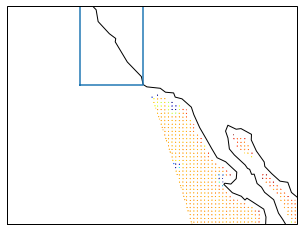

In [8]:
adir = 'C:/Users/gentemann/Google Drive/public/2019_saildrone/'
ds_usv = data_dict['saildrone_west_coast_survey_2019_sd1047']
file = 'F:/data/sat_data/smap/SSS/L2/RSS/V3/40km/2018/115/RSS_SMAP_SSS_L2C_40km_r17250_20180425T004136_2018115_FNL_V03.0.nc'
ds = xr.open_dataset(file)
ds.close()
x = ds.cellon.data
y = ds.cellat.data
z = ds.sss_smap.data
ax = plt.axes(projection=ccrs.PlateCarree())
cs1 = ax.scatter(x, y, s=1.0, c=z, edgecolor='none', cmap='jet')
minlon,maxlon,minlat,maxlat = ds_usv.lon.min().data,ds_usv.lon.max().data,ds_usv.lat.min().data,ds_usv.lat.max().data
ax.plot([minlon,maxlon,maxlon,minlon,minlon],[minlat,minlat,maxlat,maxlat,minlat])
#ax.plot(ds.cellon[jj,ii],ds.cellat[jj,ii,0],'b*')
ax.plot(ds_usv.lon[1000],ds_usv.lat[1000],'ro')
ax.coastlines()
ax.set_xlim(-130,-110)
ax.set_ylim(25,40)

# What lon range for satellite & insitu? are we going 0-360 or -180 to 180?

In [9]:
print(ds.cellon.min().data,ds.cellon.max().data)
print(ds_usv.lon.min().data,ds_usv.lon.max().data)

0.0034816479310393333 359.98931884765625
-124.9878272 -120.656


## First let's figure out what orbital files actually have data in our area of interest.  To do this, use the pyresample software

- read in the in situ data
- calculate the in situ min/max dates to know what files to check

Now we have our time of interest

- loop through the satellite data
- calculate the in situ min/max lat/lon on the same day to define a small box of interest
- use pyresample to map the data onto a predefined 0.1 deg resolution spatial grid
- subset the gridded map to the area of interest
- see if there is any valid data in that area
- if there is any valid data, go to next step

## Use the fast search kdtree which is part of pyresample software, but I think maybe comes originally from sci-kit-learn.

- read in the in situ data
- read in a single orbit of satellite data
- kdtree can't handle it when lat/lon are set to nan.  I frankly have no idea why there is orbital data for both the JPL and RSS products that have nan for the geolocation.  That isn't normal.  But, okay, let's deal with it.  
- stack the dataset scanline and cell positions into a new variable 'z'
- drop all variables from the dataset when the longitude is nan
- set up the tree
- loop through the orbital data
- only save a match if it is less than 0.25 deg distance AND time is less than any previous match
- save the satellite indices & some basic data onto the USV grid




In [11]:
area_def = load_area('areas.cfg', 'pc_world')

In [ ]:
#effort to combine the finding & collocating code
#intialize grid
adir = 'C:/Users/gentemann/Google Drive/public/2019_saildrone/'
#for name in data_dict:
for iname,name in enumerate(data_dict):
#    if iname<23:
#        continue
    area_def = load_area('areas.cfg', 'pc_world')
    rlon=np.arange(-180,180,.1)
    rlat=np.arange(90,-90,-.1)

    for isat in range(0,1):

        ds_usv,name_usv=data_dict[name],name

        if isat==0:
            fileout = 'F:/data/cruise_data/saildrone/sss_collocations/'+name_usv+'rssv4_filesave3.nc'
        if isat==1:
            fileout = 'F:/data/cruise_data/saildrone/sss_collocations/'+name_usv+'jplv4.2_filesave3.nc'   

#        if path.exists(fileout):
#            continue

        #search usv data
        minday,maxday = ds_usv.time[0],ds_usv.time[-1]
        usv_day = minday
        print(iname,name)
        print(minday.data,maxday.data)
        while usv_day<=maxday:
            ds_day = ds_usv.sel(time=slice(usv_day-np.timedelta64(1,'D'),usv_day+np.timedelta64(1,'D')))
            ilen = ds_day.time.size
            if ilen<1:   #don't run on days without any data
                continue
            minlon,maxlon,minlat,maxlat = ds_day.lon.min().data,ds_day.lon.max().data,ds_day.lat.min().data,ds_day.lat.max().data
            filelist = get_filelist_l2p(isat, usv_day)
            x,y,z = [],[],[]
            for ifile,file in enumerate(filelist):
#                if ifile!=7:
#                    continue
#            for file in filelist:
                ds = xr.open_dataset(file)
                ds.close()  
                if isat==0:  #change RSS data to conform with JPL definitions
                    ds = ds.isel(look=0)
                    ds = ds.rename({'iqc_flag':'quality_flag','cellon':'lon','cellat':'lat','sss_smap':'smap_sss','ydim_grid':'phony_dim_0','xdim_grid':'phony_dim_1'})
                    ds['lon']=np.mod(ds.lon+180,360)-180  
                if isat==1:  #change RSS data to conform with JPL definitions
                    ds = ds.rename({'row_time':'time'})

#first do a quick check using resample to project the orbit onto a grid 
#and quickly see if there is any data in the cruise area on that day
#if there is, then continue to collocation

                x = ds['lon'].fillna(-89).data 
                y = ds['lat'].fillna(-89).data 
                z = ds['smap_sss'].data 
                lons,lats,data = x,y,z 
                swath_def = SwathDefinition(lons, lats)
                
                # Resample swath to a fixed 0.01 x 0.01 grid, represented by the variable grid_def:
                # https://stackoverflow.com/questions/58065055/floor-and-ceil-with-number-of-decimals
                #changed to be just the region of the usv cruise to make grid even smaller (hopefully)
                #when working with global orbital data, work with usv BUT
                #when working with granules use ds instead of ds_usv so you just do granule region
                grid_def_lon_min = np.round(ds_day.lon.min().data - 0.5 * 10**(-2), 2)
                grid_def_lon_max = np.round(ds_day.lon.max().data + 0.5 * 10**(-2), 2)
                grid_def_lat_min = np.round(ds_day.lat.min().data - 0.5 * 10**(-2), 2)
                grid_def_lat_max = np.round(ds_day.lat.max().data + 0.5 * 10**(-2), 2)
                grid_def_lons = np.arange(grid_def_lon_min,grid_def_lon_max+0.1,0.1)
                grid_def_lats = np.arange(grid_def_lat_max,grid_def_lat_min-0.1,-0.1)
                grid_mesh_lons,grid_mesh_lats = np.meshgrid(grid_def_lons,grid_def_lats)
                # Since we have the lon and lat values for the area, we define a grid instead of an area:
                # https://pyresample.readthedocs.io/en/latest/geo_def.html#griddefinition
                grid_def = GridDefinition(lons=grid_mesh_lons,lats=grid_mesh_lats)

                result1 = resample_nearest(swath_def, data, grid_def, radius_of_influence=20000, fill_value=None)
#                result1 = resample_nearest(swath_def, data, area_def, radius_of_influence=20000, fill_value=None)
                da = xr.DataArray(result1,name='sss',coords={'lat':grid_def_lats,'lon':grid_def_lons},dims=('lat','lon'))
#                da = xr.DataArray(result1,name='sss',coords={'lat':rlat,'lon':rlon},dims=('lat','lon'))

                numdata = np.isfinite(da).sum()
                if numdata<1:
                    continue

                #chekc this!!!! for salinity data, da goes from 90 to -90, so slice max,min
                #print('lat:',maxlat,minlat)
                #print('lon:',maxlon,minlon)
#                subset = da.sel(lat = slice(maxlat,minlat),lon=slice(minlon,maxlon))
#                num_obs = np.isfinite(subset).sum()
#                if num_obs<1:  #no collocations so go to next orbit
#                    continue

                #stack xarray dataset then drop lon == nan
                ds2 = ds.stack(z=('phony_dim_0', 'phony_dim_1')).reset_index('z')
                #drop nan
                ds_drop = ds2.where(np.isfinite(ds2.lon),drop=True)
                lats = ds_drop.lat.data
                lons = ds_drop.lon.data
                inputdata = list(zip(lons.ravel(), lats.ravel()))
                tree = spatial.KDTree(inputdata)
#                ilen = ds_usv.time.size
                #find indices for ds_usv that are within 12 hours of orbit max/min time
                orbit_time = np.datetime64(ds.attrs['time_coverage_start'])-np.timedelta64(12,'h')
                orbit_time2 = np.datetime64(ds.attrs['time_coverage_end'])+np.timedelta64(12,'h')
                #the RSS salinity files have 2000-01-01 where there is missing data in orbit, so use global attributes instead
                #orbit_time = ds.time.min().data-np.timedelta64(12,'h')   #CHANGED TO +-12 HR
                #orbit_time2 = ds.time.max().data+np.timedelta64(12,'h')    
                cond = (ds_usv.time.data>orbit_time) & (ds_usv.time.data<orbit_time2)
                item = np.argwhere(cond)
                if item.sum()<1:  #no data within 12 hr of orbit
                    continue
                for iusv_index in range(int(item[0]),int(item[-1])):
#                    if (ds_usv.time[iusv_index]<orbit_time) or (ds_usv.time[iusv_index]>orbit_time2):
#                        continue
                    pts = np.array([ds_usv.lon[iusv_index], ds_usv.lat[iusv_index]])
            #        pts = np.array([ds_usv.lon[iusv]+360, ds_usv.lat[iusv]])
                    tree.query(pts,k=1)
                    i = tree.query(pts)[1]
                    rdist = tree.query(pts)[0]
                    #don't use matchups more than 25 km away
                    if rdist>.25:
                        continue
                    #use .where to find the original indices of the matched data point
                    #find by matching sss and lat, just randomly chosen variables, you could use any
                    result = np.where((ds.smap_sss == ds_drop.smap_sss[i].data) & (ds.lat == ds_drop.lat[i].data))
                    listOfCoordinates = list(zip(result[0], result[1]))
                    if len(listOfCoordinates)==0:
                        continue
                    ii, jj = listOfCoordinates[0][0],listOfCoordinates[0][1]
                    if isat==0:
                        deltaTa = ((ds_usv.time[iusv_index]-ds.time[ii,jj]).data)/ np.timedelta64(1,'m')
                    if isat==1:
                        deltaTa = ((ds_usv.time[iusv_index]-ds.time[ii]).data)/ np.timedelta64(1,'m')
                    if np.abs(deltaTa)<np.abs(ds_usv.deltaT[iusv_index].data):
                        ds_usv.deltaT[iusv_index]=deltaTa
                        ds_usv.smap_SSS[iusv_index]=ds.smap_sss[ii,jj]
                        ds_usv.smap_iqc_flag[iusv_index]=ds.quality_flag[ii,jj]
                        ds_usv.smap_name[iusv_index]=file
                        ds_usv.smap_dist[iusv_index]=rdist
                        ds_usv.smap_ydim[iusv_index]=ii
                        ds_usv.smap_xdim[iusv_index]=jj
            usv_day += np.timedelta64(1,'D')
        ds_usv.to_netcdf(fileout)



0 PMEL_Arctic_2015_sd126-ALL-1_min-v1
2015-05-12T20:00:16.000000000 2015-07-28T19:58:16.000000000
1 PMEL_Arctic_2015_sd128-ALL-1_min-v1
2015-05-04T00:00:15.000000000 2015-07-28T19:58:16.000000000
2 PMEL_Arctic_2016_sd126-ALL-1_min-v1
2016-05-23T00:01:15.000000000 2016-09-03T18:02:15.000000000
3 PMEL_Arctic_2016_sd128-ALL-1_min-v1
2016-05-23T00:01:15.000000000 2016-09-03T18:02:15.000000000
4 saildrone-gen_4-baja_2018-sd1002-20180411T180000-20180611T055959-1_minutes-v1
2018-04-11T18:00:00.000000000 2018-06-11T05:57:00.000000000
5 saildrone-gen_4-shark-2018-sd1001-20180315T000000-20180529T235959-1_minutes-v1.1581626958976
2018-03-15T00:00:00.000000000 2018-05-29T23:59:00.000000000
6 saildrone-gen_4-shark-2018-sd1004-20180315T000000-20180617T235959-1_minutes-v1.1581627077777
2018-03-15T00:00:00.000000000 2018-06-17T23:59:00.000000000
7 saildrone-gen_5-1021_atlantic-sd1021-20190525T000000-20191021T235959-1_minutes-v1.1571806429446_(1)
2019-05-25T00:00:00.000000000 2019-10-21T23:59:00.000000

In [ ]:
#look for repeat obs
#remove any duplicates
_, index = np.unique(ds_tem.smap_name, return_index=True)
#ds=ds.isel(time=index)


In [ ]:
#find values with same filename, scan number, and cell position
#this takes the mean, but it may mix up measurements from 'good' obs with 'bad' obs
#should either only use lowest iqc or ?
ds_tem2 = ds_tem   #.drop('traj')
ds_new = ds_tem
ds_mn = []
#ds_tem2.drop({'obs','traj'})
#for i in range(4): #len(ds_tem)):
while len(ds_new)>1:
    cond = ((ds_tem2.smap_name==ds_tem2.smap_name[i]) 
            & (ds_tem2.smap_ydim==ds_tem2.smap_ydim[i]) 
            & (ds_tem2.smap_xdim==ds_tem2.smap_xdim[i]))
    subset = ds_tem2.where(cond,drop=True)  #repeat obs
    ds_mn = subset.mean(keep_attrs=True,skipna=True)
    ds_mn['time'] = subset.time.mean()
    ds_mn = ds_mn.assign_coords({'ob':i})
    if i==0:
        ds_mn2 = ds_mn
    else:
        ds_mn2 = xr.concat([ds_mn2,ds_mn],dim='ob')
    ds_new = ds_tem2.where(~cond,drop=True)  #data with repeat obs removed
    

In [ ]:
ds_new

In [ ]:
subset.smap_iqc_flag

In [ ]:
ds_mn2

In [ ]:
ds_usv.smap_iqc_flag[10000:].plot()

In [ ]:
ds.quality_flag[200:400,330:400].plot(vmin=0,vmax=2192)
plt.grid()

In [ ]:
ds.smap_sss[200:400,330:400].plot()
plt.grid()

In [ ]:
for i in range(300,350,5):
    print(ds.smap_sss[i,370].data,ds.quality_flag[i,370].data)


In [ ]:
qc = ds.quality_flag.attrs['flag_meanings'].split(' ')
for i in range(16):
    print(i,qc[i])

In [ ]:
# 0     1      2       3     4       5     6     7       8      9      10     11      12       13
0*2**0+0*2**1+0*2**2+0*2**3+0*2**4+0*2**5+0*2**6+0*2**7+0*2**8+0*2**9+1*2**10+0*2**11+0*2**12+0*2**13
#bytearray(8192)

In [ ]:
print(ds.smap_sss[320,360:370].data)
print(ds.quality_flag[320,360:370].data)


In [ ]:
for ifile,file in enumerate(filelist):
    if ifile==7:
        ds = xr.open_dataset(file)
        ds = ds.isel(look=0)
        ds = ds.rename({'iqc_flag':'quality_flag','cellon':'lon','cellat':'lat','sss_smap':'smap_sss','ydim_grid':'phony_dim_0','xdim_grid':'phony_dim_1'})
        ds['lon']=np.mod(ds.lon+180,360)-180  
        plt.scatter(ds.lon,ds.lat)
        plt.scatter(ds_day.lon,ds_day.lat)
        plt.title(ifile)
        plt.xlim(-140,-100)
        plt.ylim(0,50)
    

In [ ]:
ds_usv.time

In [ ]:

i = np.argwhere(cond)


In [ ]:
print(ds_usv.time[i[-1]].data,orbit_time2)

In [ ]:
minlon,maxlon,minlat,maxlat = ds_day.lon.min().data,ds_day.lon.max().data,ds_day.lat.min().data,ds_day.lat.max().data
filelist = get_filelist_l2p(isat, usv_day)
ds = xr.open_mfdataset(filelist,combine='nested',concat_dim='phony_dim_1')


In [ ]:
for iusv_index in range(ilen):
    if (ds_usv.time[iusv_index]<orbit_time) or (ds_usv.time[iusv_index]>orbit_time2):
        continue
    pts = np.array([ds_usv.lon[iusv_index], ds_usv.lat[iusv_index]])
#        pts = np.array([ds_usv.lon[iusv]+360, ds_usv.lat[iusv]])
    tree.query(pts,k=1)
    i = tree.query(pts)[1]
    rdist = tree.query(pts)[0]
    #don't use matchups more than 25 km away
    if rdist>.25:
        continue
    #use .where to find the original indices of the matched data point
    #find by matching sss and lat, just randomly chosen variables, you could use any
    result = np.where((ds.smap_sss == ds_drop.smap_sss[i].data) & (ds.lat == ds_drop.lat[i].data))
    listOfCoordinates = list(zip(result[0], result[1]))
    if len(listOfCoordinates)==0:
        continue
    ii, jj = listOfCoordinates[0][0],listOfCoordinates[0][1]
    if isat==0:
        deltaTa = ((ds_usv.time[iusv_index]-ds.time[ii,jj]).data)/ np.timedelta64(1,'m')
    if isat==1:
        deltaTa = ((ds_usv.time[iusv_index]-ds.time[ii]).data)/ np.timedelta64(1,'m')
    if np.abs(deltaTa)<np.abs(ds_usv.deltaT[iusv_index].data):
        ds_usv.deltaT[iusv_index]=deltaTa
        ds_usv.smap_SSS[iusv_index]=ds.smap_sss[ii,jj]
        ds_usv.smap_iqc_flag[iusv_index]=ds.quality_flag[ii,jj]
        ds_usv.smap_name[iusv_index]=file
        ds_usv.smap_dist[iusv_index]=rdist
        ds_usv.smap_ydim[iusv_index]=ii
        ds_usv.smap_xdim[iusv_index]=jj


In [ ]:
print(ds_usv.time[1800].data,orbit_time)

In [ ]:
                orbit_time = ds.time.max().data-np.timedelta64(1,'D')
                orbit_time2 = ds.time.max().data+np.timedelta64(1,'D')    
                ds_tem = ds_usv.sel(time=slice(orbit_time,orbit_time2))


In [ ]:
ds_tem

In [ ]:
ds.quality_flag